In [4]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import numpy as np
from PIL import Image
import torch.onnx
from datetime import datetime
import os
import sys
import torch
import io
import time
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import unicodedata
import re
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
# from miscc.config import cfg
# from miscc.utils import build_super_images2
# from model import RNN_ENCODER, G_NET
import pickle
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
import fnmatch
import scipy.io
import scipy.misc
import tensorflow as tf
import imageio
from IPython.display import Image
from keras.preprocessing.image import load_img, img_to_array
from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b
from keras.applications import vgg19
from keras import backend as K
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg

Using TensorFlow backend.


In [231]:
text = open('sciencetext.csv', 'rb').read().decode(encoding='utf-8')

In [232]:
len(text)

406939

In [233]:
vocab = sorted(set(text))

In [234]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
text_as_int = np.array([char2idx[c] for c in text])

In [235]:
seq_length = 100
examples_per_epoch = len(text)//seq_length
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [236]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

"\ufeffGreetings children, it's me, Captain Disillusion. Too many plot developments have been happening aro"
'und here lately\nit used to be about the work not feelings. Debunking hoaxes and\nsolving viral-video m'
"ysteries no one else could solve\nLike this little gem that's been paying regular visits to my inbox f"
'or the past five years.\n[Jingle music] Host : ""Hi and welcome to this episode of ""Can you imagine""'
'...\nA segment in a low-budget promotional webseries from the Rochester Institute of Technology featur'


In [237]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [238]:
BATCH_SIZE = 32 #Lowered batch size
steps_per_epoch = examples_per_epoch//BATCH_SIZE
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [239]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

In [240]:
if tf.test.is_gpu_available():
    rnn = tf.keras.layers.CuDNNGRU
else:
    import functools
    rnn = functools.partial(
    tf.keras.layers.GRU, recurrent_activation='sigmoid')

In [241]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    rnn(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform', stateful=True),
    tf.keras.layers.Dense(vocab_size)])
    return model

In [242]:
model = build_model(
  vocab_size = len(vocab), 
  embedding_dim=embedding_dim, 
  rnn_units=rnn_units, 
  batch_size=BATCH_SIZE)

In [243]:
for input_example_batch, target_example_batch in dataset.take(1): 
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(32, 100, 111) # (batch_size, sequence_length, vocab_size)


In [244]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (32, None, 256)           28416     
_________________________________________________________________
cu_dnngru_11 (CuDNNGRU)      (32, None, 1024)          3938304   
_________________________________________________________________
dense_19 (Dense)             (32, None, 111)           113775    
Total params: 4,080,495
Trainable params: 4,080,495
Non-trainable params: 0
_________________________________________________________________


In [245]:
sampled_indices = tf.random.multinomial(example_batch_predictions[0], num_samples=1) 
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [246]:
def loss(labels, logits):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 111)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.711887


In [247]:
model.compile(
    optimizer = tf.train.AdamOptimizer(),
    loss = loss)

In [248]:
checkpoint_dir = './text100'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [249]:
EPOCHS=60
history = model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])

Epoch 1/60
127/127 [==============================] - 6s 46ms/step - loss: 2.8850: 0s -
Epoch 2/60
127/127 [==============================] - 6s 45ms/step - loss: 2.2113
Epoch 3/60
127/127 [==============================] - 5s 43ms/step - loss: 1.9448
Epoch 4/60
127/127 [==============================] - 8s 61ms/step - loss: 1.7576
Epoch 5/60
127/127 [==============================] - 5s 43ms/step - loss: 1.6239
Epoch 6/60
127/127 [==============================] - 6s 44ms/step - loss: 1.5204
Epoch 7/60
127/127 [==============================] - 8s 62ms/step - loss: 1.4410
Epoch 8/60
127/127 [==============================] - 6s 45ms/step - loss: 1.3704
Epoch 9/60
127/127 [==============================] - 6s 45ms/step - loss: 1.3048
Epoch 10/60
127/127 [==============================] - 7s 59ms/step - loss: 1.2448
Epoch 11/60
127/127 [==============================] - 6s 45ms/step - loss: 1.1772
Epoch 12/60
127/127 [==============================] - 6s 44ms/step - loss: 1.1156
Epoch 1

In [252]:
tf.train.latest_checkpoint(checkpoint_dir)

'./text100/ckpt_60'

In [253]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (1, None, 256)            28416     
_________________________________________________________________
cu_dnngru_12 (CuDNNGRU)      (1, None, 1024)           3938304   
_________________________________________________________________
dense_20 (Dense)             (1, None, 111)            113775    
Total params: 4,080,495
Trainable params: 4,080,495
Non-trainable params: 0
_________________________________________________________________


In [272]:
def generate_text(model, start_string):    
    num_generate = random.randint(20,50)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 0.5
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])
    return (start_string + ''.join(text_generated))

In [313]:
generatedtext = generate_text(model, start_string=u"A blue bird")

In [15]:
print(generatedtext)

A blue bird flying in the sky


In [7]:
# Function to vectorize input caption

def vectorize_caption(wordtoix, caption, copies=2):
    tokens = caption.split(' ')
    cap_v = []
    for t in tokens:
        t = t.strip().encode('ascii', 'ignore').decode('ascii')
        if len(t) > 0 and t in wordtoix:
            cap_v.append(wordtoix[t])
    captions = np.zeros((copies, len(cap_v)))
    for i in range(copies):
        captions[i,:] = np.array(cap_v)
    cap_lens = np.zeros(copies) + len(cap_v)
    return captions.astype(int), cap_lens.astype(int)

x = pickle.load(open('data/captions.pickle', 'rb'))
ixtoword = x[2]
wordtoix = x[3]
del x

In [8]:
# Loading models

word_len = len(wordtoix)

text_encoder = RNN_ENCODER(word_len, nhidden=cfg.TEXT.EMBEDDING_DIM)
state_dict = torch.load(cfg.TRAIN.NET_E, map_location=lambda storage, loc: storage)
text_encoder.load_state_dict(state_dict)
text_encoder.eval()
        
netG = G_NET()
state_dict = torch.load(cfg.TRAIN.NET_G, map_location=lambda storage, loc: storage)
netG.load_state_dict(state_dict)
netG.eval()

C:\Users\c1yeung\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


G_NET(
  (ca_net): CA_NET(
    (fc): Linear(in_features=256, out_features=400, bias=True)
    (relu): GLU()
  )
  (h_net1): INIT_STAGE_G(
    (fc): Sequential(
      (0): Linear(in_features=200, out_features=16384, bias=False)
      (1): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GLU()
    )
    (upsample1): Sequential(
      (0): Upsample(scale_factor=2, mode=nearest)
      (1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): GLU()
    )
    (upsample2): Sequential(
      (0): Upsample(scale_factor=2, mode=nearest)
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): GLU()
    )
    (upsample3): Sequential(
      (0): Upsample(scale_factor=2, mode=nearest)
      (

In [9]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [41]:
def generate(caption, copies=2):
    # load word vector
    captions, cap_lens  = vectorize_caption(wordtoix, caption, copies)
    n_words = len(wordtoix)

    # only one to generate
    batch_size = captions.shape[0]

    nz = cfg.GAN.Z_DIM
    captions = Variable(torch.from_numpy(captions), volatile=True)
    cap_lens = Variable(torch.from_numpy(cap_lens), volatile=True)
    noise = Variable(torch.FloatTensor(batch_size, nz), volatile=True)
    

    # extract word embedding
    hidden = text_encoder.init_hidden(batch_size)
    words_embs, sent_emb = text_encoder(captions.long(), cap_lens, hidden)
    mask = (captions.long() == 0)

    
    # generate fake images
    noise.data.normal_(0, 1)
    fake_imgs, attention_maps, _, _ = netG(noise, sent_emb, words_embs, mask)
    cap_lens_np = cap_lens.cpu().data.numpy()

    # storing to blob storage
    container_name = "images"
    full_path = "https://attgan.blob.core.windows.net/images/%s"
    prefix = datetime.now().strftime('%Y/%B/%d/%H_%M_%S_%f')
    imgs = []
    
    # return image
    for j in range(batch_size):
        for k in range(len(fake_imgs)):
            im = fake_imgs[k][j].data.cpu().numpy()
            im = (im + 1.0) * 127.5
            im = im.astype(np.uint8)
            im = np.transpose(im, (1, 2, 0))
            imgs.append(im)
    return imgs[-1]

C:\Users\c1yeung\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\c1yeung\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\c1yeung\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':


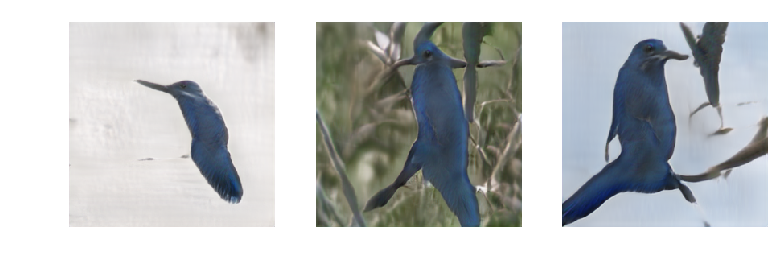

In [53]:
# generate k number of images based on the caption generated previously
k = 3
gen_images = []
for _ in range(k):
    gen_images.append(generate(generatedtext))

# show the generated images
plt.figure(dpi=150)
for i in range(k):
    plt.subplot(1,k,i+1)
    plt.imshow(gen_images[i])
    plt.axis('off')

In [54]:
# save the generated images for style transfer later
for i in range(k):
    im = Image.fromarray(gen_images[i])
    im.save("bird" + str(i+1) + ".png")

In [83]:
iterations = 10
total_variation_weight = 1.0 
style_weight = 1.0
content_weight = 0.025
content = plt.imread('bird3.png')
style = plt.imread('colors.jpg')
width, height = content.shape[1], content.shape[0]
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [6]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [85]:
content_image = K.variable(preprocess_image('bird3.png'))
style_image = K.variable(preprocess_image('colors.jpg'))
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))
input_tensor = K.concatenate([content_image, style_image, combination_image], axis=0)
model = vgg19.VGG19(input_tensor=input_tensor,weights='imagenet', include_top=False)

In [86]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [24]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [87]:
loss = K.variable(0.)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features, combination_features)

In [88]:
feature_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [89]:
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [90]:
grads = K.gradients(loss, combination_image)
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)

In [91]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [92]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [93]:
evaluator = Evaluator()

In [94]:
x = preprocess_image('bird3.png')

In [95]:
result_prefix ='results_'

In [96]:
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    img2 = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    imageio.imwrite(fname, img2)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 20141090000.0
Image saved as results__at_iteration_0.png
Iteration 0 completed in 8s
Start of iteration 1
Current loss value: 13701972000.0
Image saved as results__at_iteration_1.png
Iteration 1 completed in 19s
Start of iteration 2
Current loss value: 12165228000.0
Image saved as results__at_iteration_2.png
Iteration 2 completed in 18s
Start of iteration 3
Current loss value: 11312339000.0
Image saved as results__at_iteration_3.png
Iteration 3 completed in 18s
Start of iteration 4
Current loss value: 10842411000.0
Image saved as results__at_iteration_4.png
Iteration 4 completed in 19s
Start of iteration 5
Current loss value: 10451741000.0
Image saved as results__at_iteration_5.png
Iteration 5 completed in 19s
Start of iteration 6
Current loss value: 10184747000.0
Image saved as results__at_iteration_6.png
Iteration 6 completed in 7s
Start of iteration 7
Current loss value: 9955375000.0
Image saved as results__at_iteration_7.png
Iteration 7 comp

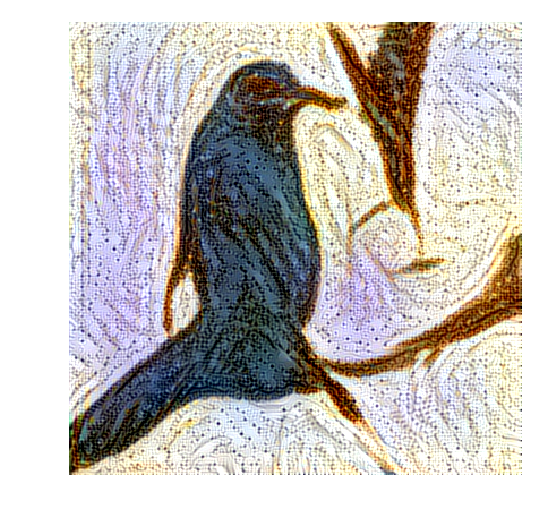

In [97]:
plt.figure(dpi=150)
plt.axis('off')
plt.imshow(img2)
img2_ = Image.fromarray(img2)
img2_.save("bird3ST.png")